In [81]:
%load_ext autoreload
%autoreload 2

import sys, os
sys.path.append("../") # go to parent dir

import warnings
warnings.filterwarnings("ignore")

# version
import torch
import torchvision
import torch.utils.data as data
print(torch.__version__)
print(torchvision.__version__)

from models.base_cfg import ssd300_cfg as cfg
from models.base_cfg import ML_WEIGHTS_PATH, DS01_CLASSES
from utils import ssd

import cv2
from utils import data_processor

import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
1.5.0
0.6.0a0+82fd1c8


In [82]:
cfg

{'num_classes': 6,
 'input_size': 300,
 'base': 300,
 'base_model': 'vgg16_reducedfc.pth',
 'bbox_aspect_num': [4, 6, 6, 6, 4, 4],
 'feature_maps': [38, 19, 10, 5, 3, 1],
 'steps': [8, 16, 32, 64, 100, 300],
 'min_sizes': [30, 60, 111, 162, 213, 264],
 'max_sizes': [60, 111, 162, 213, 264, 315],
 'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
 'cuda': True,
 'train_labeled_file': '/home/redne/mnt/project_zero/project_zero/ds1/experiments/data/train_labels_dev.npy',
 'val_labeled_file': '/home/redne/mnt/project_zero/project_zero/ds1/experiments/data/val_labels_dev.npy',
 'img_dir': '/home/redne/mnt/project_zero/project_zero/ds1/parsed/',
 'logs': 'checkpoints/logs.txt',
 'color_mean': (104, 117, 123),
 'variance': ([0.1, 0.2],)}

In [83]:
if torch.cuda.is_available():
    use_cuda = torch.cuda.is_available()
    if cfg['cuda']:
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
    if not cfg['cuda']:
        print("WARNING: It looks like you have a CUDA device, but aren't " +
              "using CUDA.\nRun with --cuda for optimal training speed.")
        torch.set_default_tensor_type('torch.FloatTensor')
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    
device = torch.device("cuda" if use_cuda else "cpu")

print(f'device : {device}')


device : cuda


### 1. Load the SSD architecture and the pretrained weights

In [84]:
#root = '/home/redne/mnt/project_zero/project_zero/ds1/parsed/'
#train_img_list, train_anno_list, val_img_list, val_anno_list = make_datapath_list(rootpath)
imgpath, annopath = data_processor.make_datapath_list(cfg['img_dir'])
train_img_list, train_anno_list, val_img_list, val_anno_list = imgpath[:-100], annopath[:-100], imgpath[-100:], annopath[-100:]


"""
# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()
dataset = torch.utils.data.Subset(dataset, indices[:-50])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-50:])
"""

# Dataset
voc_classes =  DS01_CLASSES

train_dataset = data_processor.VOCDataset(train_img_list, train_anno_list, phase="train", 
                                          transform=data_processor.VOC_DataTransform(
                                              cfg['input_size'], cfg['color_mean']), 
                                          transform_anno=data_processor.Anno_json(voc_classes))

val_dataset = data_processor.VOCDataset(val_img_list, val_anno_list, phase="val",
                                    transform=data_processor.VOC_DataTransform(
    cfg['input_size'], cfg['color_mean']), transform_anno=data_processor.Anno_json(voc_classes))


batch_size = 32
#batch_size = 8

train_dataloader = data.DataLoader(
    train_dataset, batch_size=batch_size, shuffle=True, collate_fn=data_processor.od_collate_fn)

val_dataloader = data.DataLoader(
    val_dataset, batch_size=batch_size, shuffle=False, collate_fn=data_processor.od_collate_fn)


dataloaders_dict = {"train": train_dataloader, "val": val_dataloader}
dataloaders_dict

{'train': <torch.utils.data.dataloader.DataLoader at 0x7f746c267550>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x7f746cb27090>}


## Trainign SSD

- First download the fc-reduced VGG-16 PyTorch base network weights at: https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth
- By default, we assume you have downloaded the file in the ssd.pytorch/weights dir:


```
cd ~/mnt/project_zero/pytorch/weights/
wget https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth
#adjust the keys in the weights file to fit for current model
python3 vggweights.py
cd ..
```

https://github.com/yczhang1017/SSD_resnet_pytorch#training-ssd


- Download the PyTorch pre-trained SSD300 model on VOC from [here](https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth):
    
_https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth_

In [85]:
cfg

{'num_classes': 6,
 'input_size': 300,
 'base': 300,
 'base_model': 'vgg16_reducedfc.pth',
 'bbox_aspect_num': [4, 6, 6, 6, 4, 4],
 'feature_maps': [38, 19, 10, 5, 3, 1],
 'steps': [8, 16, 32, 64, 100, 300],
 'min_sizes': [30, 60, 111, 162, 213, 264],
 'max_sizes': [60, 111, 162, 213, 264, 315],
 'aspect_ratios': [[2], [2, 3], [2, 3], [2, 3], [2], [2]],
 'cuda': True,
 'train_labeled_file': '/home/redne/mnt/project_zero/project_zero/ds1/experiments/data/train_labels_dev.npy',
 'val_labeled_file': '/home/redne/mnt/project_zero/project_zero/ds1/experiments/data/val_labels_dev.npy',
 'img_dir': '/home/redne/mnt/project_zero/project_zero/ds1/parsed/',
 'logs': 'checkpoints/logs.txt',
 'color_mean': (104, 117, 123),
 'variance': ([0.1, 0.2],)}

In [86]:
!ls -lh '/home/redne/mnt/project_zero/pytorch/weights/'

total 264M
-rwxrwxrwx 1 root root 93M May 31 20:27 dev2_ssd300_10_053120.pth
-rwxrwxrwx 1 root root 93M May 31 19:41 dev_ssd300_10_053120.pth
-rwxrwxrwx 1 root root 79M May 31 12:37 vgg16_reducedfc.pth


In [87]:
os.path.join(ML_WEIGHTS_PATH, cfg['base_model'])

'/home/redne/mnt/project_zero/pytorch/weights/vgg16_reducedfc.pth'

In [88]:
net = ssd.build_ssd(phase="train",num_classes=cfg['num_classes'])
vgg_weights = torch.load(os.path.join(ML_WEIGHTS_PATH, cfg['base_model']))
net.vgg.load_state_dict(vgg_weights)




<All keys matched successfully>

In [89]:
import torch.nn as nn
import torch.nn.init as init

def weights_init(m):
    if isinstance(m, nn.Conv2d):
        init.kaiming_normal_(m.weight.data)
        if m.bias is not None:  
            nn.init.constant_(m.bias, 0.0)
            
net.extras.apply(weights_init)
net.loc.apply(weights_init)
net.conf.apply(weights_init)

import torch.backends.cudnn as cudnn
if cfg['cuda']:
    net = torch.nn.DataParallel(net)
    cudnn.benchmark = True

In [90]:
from utils.ssd import MultiBoxLoss
import torch.optim as optim

criterion = MultiBoxLoss(jaccard_thresh=0.5, neg_pos=3, device=device)

optimizer = optim.SGD(net.parameters(), lr=1e-3,
                      momentum=0.9, weight_decay=5e-4)

In [92]:
def train_model(net, dataloaders_dict, criterion, optimizer, num_epochs):

    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    print("Training on：", device)


    net.to(device)
    torch.backends.cudnn.benchmark = True

    iteration = 1
    epoch_train_loss = 0.0
    epoch_val_loss = 0.0
    logs = []

    for epoch in range(num_epochs+1):

        t_epoch_start = time.time()
        t_iter_start = time.time()

        print('-------------')
        print('Epoch {}/{}'.format(epoch+1, num_epochs))
        print('-------------')

        for phase in ['train', 'val']:
            if phase == 'train':
                net.train() 
                print('（train）')
            else:
                if((epoch+1) % 10 == 0):
                    net.eval()
                    print('-------------')
                    print('（val）')
                else:
                    
                    continue

            for images, targets in dataloaders_dict[phase]:


                images = images.to(device)
                targets = [ann.to(device) for ann in targets]

                optimizer.zero_grad()
                
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = net(images)

                    loss_l, loss_c = criterion(outputs, targets)
                    loss = loss_l + loss_c


                    if phase == 'train':
                        loss.backward()

                        
                        nn.utils.clip_grad_value_(
                            net.parameters(), clip_value=2.0)

                        optimizer.step()

                        if (iteration % 10 == 0):  
                            t_iter_finish = time.time()
                            duration = t_iter_finish - t_iter_start
                            print('>> training iter {} || Loss: {:.4f} || 10iter: {:.4f} sec.'.format(
                                iteration, loss.item(), duration))
                            t_iter_start = time.time()

                        epoch_train_loss += loss.item()
                        iteration += 1
                        
                    else:
                        epoch_val_loss += loss.item()

        t_epoch_finish = time.time()
        print('-------------')
        print('epoch {} || Epoch_TRAIN_Loss:{:.4f} ||Epoch_VAL_Loss:{:.4f}'.format(
            epoch+1, epoch_train_loss, epoch_val_loss))
        print('timer:  {:.4f} sec.'.format(t_epoch_finish - t_epoch_start))
        t_epoch_start = time.time()

        log_epoch = {'epoch': epoch+1,
                     'train_loss': epoch_train_loss, 'val_loss': epoch_val_loss}
        logs.append(log_epoch)
        df = pd.DataFrame(logs)
        df.to_csv("../outputs/log_output_dev3_060120.csv")

        epoch_train_loss = 0.0
        epoch_val_loss = 0.0

        
        if ((epoch+1) % 10 == 0):
            torch.save(net.state_dict(), ML_WEIGHTS_PATH + 'dev3_ssd300_' +
                       str(epoch+1) + '_060120.pth')

In [94]:
import random
import time

import cv2
import numpy as np
import pandas as pd

num_epochs= 50
train_model(net, dataloaders_dict, criterion, optimizer, num_epochs=num_epochs)

Training on： cuda:0
-------------
Epoch 1/50
-------------
（train）
>> training iter 10 || Loss: 11.1827 || 10iter: 98.8239 sec.
-------------
epoch 1 || Epoch_TRAIN_Loss:168.3871 ||Epoch_VAL_Loss:0.0000
timer:  125.3869 sec.
-------------
Epoch 2/50
-------------
（train）
>> training iter 20 || Loss: 11.2703 || 10iter: 68.8174 sec.
-------------
epoch 2 || Epoch_TRAIN_Loss:146.4156 ||Epoch_VAL_Loss:0.0000
timer:  125.8278 sec.
-------------
Epoch 3/50
-------------
（train）
>> training iter 30 || Loss: 9.7713 || 10iter: 37.5422 sec.
-------------
epoch 3 || Epoch_TRAIN_Loss:128.4520 ||Epoch_VAL_Loss:0.0000
timer:  123.8475 sec.
-------------
Epoch 4/50
-------------
（train）
>> training iter 40 || Loss: 9.3273 || 10iter: 9.5673 sec.
>> training iter 50 || Loss: 9.0907 || 10iter: 99.4272 sec.
-------------
epoch 4 || Epoch_TRAIN_Loss:116.9756 ||Epoch_VAL_Loss:0.0000
timer:  128.2546 sec.
-------------
Epoch 5/50
-------------
（train）
>> training iter 60 || Loss: 9.2781 || 10iter: 77.5786 s

### Reviewing initial results

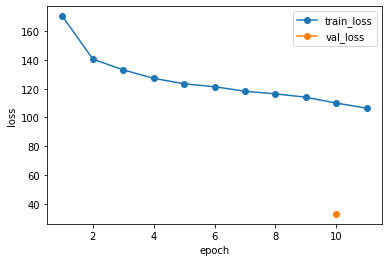

In [56]:
import matplotlib.pyplot as plt
import pandas as pd


data = pd.read_csv("../outputs/log_output_dev_053120.csv",encoding = 'UTF8')

plt.plot(data['epoch'],data['train_loss'], marker='o', label='train_loss')
plt.plot(data['epoch'][9:50:10],data['val_loss'][9:50:10], marker='o',label="val_loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

In [54]:
df = pd.read_csv("../outputs/log_output_dev_053120.csv",encoding = 'UTF8')

In [55]:
df.head()

,Unnamed: 0,epoch,train_loss,val_loss
0,0,1,170.494267,0.0
1,1,2,140.631291,0.0
2,2,3,133.139671,0.0
3,3,4,127.261935,0.0
4,4,5,123.464974,0.0
